In [2]:
%matplotlib inline


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, \
    cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, \
    PowerTransformer, StandardScaler

import warnings
warnings.filterwarnings("ignore")

## Задача: обучите случайный лес для предсказания возраста морских ушек

- Попробуйте полиномиальные признаки 2-го порядка;
- Постройте барплоты с важностями исходных признаков и признаков, полученных с помощью `PolynomialFeatures` (включая исходные);
- Постройте график зависимости R2 гребневой регрессии от количества задействованных полиномиальных признаков (добавляйте признаки в порядке убывания значимости).

In [3]:
train_url = 'https://raw.githubusercontent.com/Katalinach/ML-Datasets/master/abalone_train.csv?token=ANTWLAFF2MOZ42YHG2P2K3C7G666E'
test_url = 'https://raw.githubusercontent.com/Katalinach/ML-Datasets/master/abalone_test.csv?token=ANTWLAH4CJPLNN7SPWTAIQC7G667O'
train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

In [4]:
train_df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,I,0.465,0.360,0.105,0.4520,0.2200,0.1590,0.1035,9
1,M,0.630,0.510,0.170,1.1885,0.4915,0.3065,0.3480,7
2,M,0.540,0.435,0.140,0.7345,0.3300,0.1595,0.2130,9
3,I,0.405,0.300,0.090,0.2690,0.1030,0.0670,0.1100,6
4,M,0.600,0.485,0.175,1.2675,0.4995,0.2815,0.3800,13


In [5]:
X_train = train_df.drop(['Rings'], axis=1)
y_train = train_df['Rings']
X_test = test_df.drop(['Rings'], axis=1)
y_test = test_df['Rings']

In [6]:
# закодируем признак 'Sex'с помощью get_dummies

X_train = pd.get_dummies(X_train, columns=['Sex'])
X_test = pd.get_dummies(X_test, columns=['Sex'])

In [7]:
X_train.shape

(2677, 10)

In [ ]:
# Обучите случайный лес на задаче предсказания возраста морских ушек
# подберем значение n_estimators

clf_rf = RandomForestClassifier()
n_estimators = np.arange(1, 200, 2)

gs = GridSearchCV(clf_rf, param_grid={'n_estimators': n_estimators}, cv=3, scoring='r2')
gs.fit(X_train, y_train)
gs.best_params_

{'n_estimators': 115}

In [ ]:
# обучим модель

clf_rf = RandomForestClassifier(**gs.best_params_)
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

0.37179123446915596

In [ ]:
# Попробуйте полиномиальные признаки 2-го порядка

poly_transformer = PolynomialFeatures(degree=2) # создадим полиномиальный объект степени 2
poly_transformer.fit(X_train) # тренировка полиномиальных признаков

poly_features_train = poly_transformer.transform(X_train) # трансформация признаков
poly_features_test = poly_transformer.transform(X_test)

In [ ]:
poly_features_train.shape

(2677, 66)

In [ ]:
# подберем значение n_estimators

clf_rf_poly = RandomForestClassifier()
n_estimators = np.arange(1, 200, 2)

gs = GridSearchCV(clf_rf_poly, param_grid={'n_estimators': n_estimators}, cv=3, scoring='r2')
gs.fit(poly_features_train, y_train)
gs.best_params_

{'n_estimators': 143}

In [ ]:
# обучим модель

clf_rf_poly = RandomForestClassifier(**gs.best_params_)
clf_rf_poly.fit(poly_features_train, y_train)
y_pred = clf_rf_poly.predict(poly_features_test)
r2 = r2_score(y_test, y_pred)
r2

0.35850862022035257

Важность признаков
0. Shell weight 0.166557 
1. Shucked weight 0.152945 
2. Viscera weight 0.147861 
3. Whole weight 0.146266 
4. Length 0.119072 
5. Diameter 0.113549 
6. Height 0.099856 
7. Sex_M 0.018973 
8. Sex_F 0.017908 
9. Sex_I 0.017014 


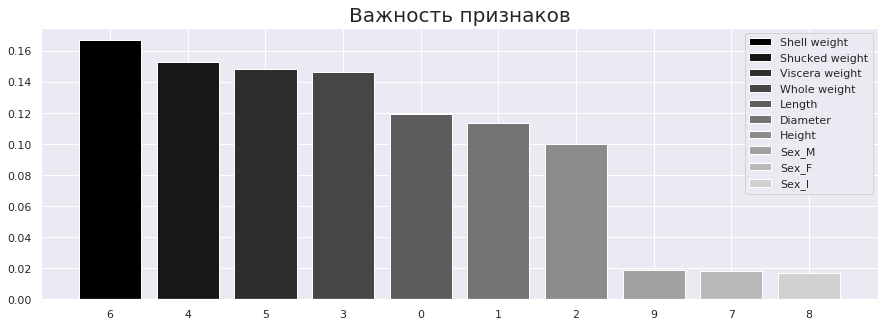

In [ ]:
# Постройте барплоты с важностями исходных признаков

features = list(X_train.columns)
importances = clf_rf.feature_importances_
indices = np.argsort(importances)[::-1]
num_to_plot = 10

print('Важность признаков')
  
for f in range(num_to_plot):
    print("%d. %s %f " % (f, 
            features[indices[f]], 
            importances[indices[f]]))

plt.figure(figsize=(15, 5))
plt.title('Важность признаков', fontdict={'fontsize': 20})
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
               color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]))
ticks = plt.xticks(range(num_to_plot), indices)
plt.legend(bars, [''.join(features[i]) 
                  for i in indices]);

Важность признаков
0. poly_34 0.032384 
1. poly_56 0.031735 
2. poly_17 0.031258 
3. poly_7 0.030662 
4. poly_26 0.030471 
5. poly_52 0.029394 
6. poly_41 0.027626 
7. poly_33 0.027073 
8. poly_25 0.025763 
9. poly_22 0.025640 


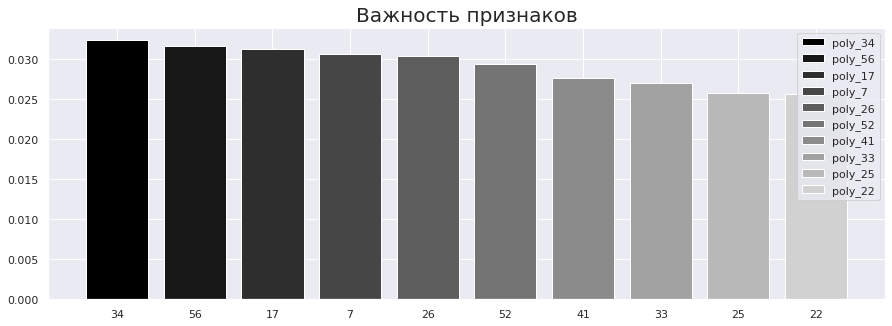

In [ ]:
# и признаков, полученных с помощью PolynomialFeatures (включая исходные)

columns = (['poly_' + str(i) for i in range(66)])
poly_features_train_df = pd.DataFrame(poly_features_train, columns=columns)
poly_features_test_df = pd.DataFrame(poly_features_test, columns=columns)
features = list(poly_features_train_df.columns)
importances = clf_rf_poly.feature_importances_
indices = np.argsort(importances)[::-1]
num_to_plot = 10

print('Важность признаков')
  
for f in range(num_to_plot):
    print("%d. %s %f " % (f, 
            features[indices[f]], 
            importances[indices[f]]))

plt.figure(figsize=(15, 5))
plt.title('Важность признаков', fontdict={'fontsize': 20})
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
               color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]))
ticks = plt.xticks(range(num_to_plot), indices)
plt.legend(bars, [''.join(features[i]) 
                  for i in indices]);

In [ ]:
# создадим датафрейм с новыми признаками, расположенными в порядке убывания важности

new_features = []
new_importances = []
  
for f in range(66):
    new_features.append(features[indices[f]])
    new_importances.append(importances[indices[f]])

In [ ]:
new_features = pd.concat([pd.DataFrame(new_features), pd.DataFrame(new_importances)], axis=1, names = ['feature', 'importance'], ignore_index=False)
new_features.columns = ['feature', 'importance']
new_features = list(new_features['feature'])

In [ ]:
X_train_poly = poly_features_train_df[new_features]
X_test_poly = poly_features_test_df[new_features]

In [ ]:
X_train_poly.head()

,poly_34,poly_56,poly_17,poly_7,poly_26,poly_52,poly_41,poly_33,poly_25,poly_22,poly_15,poly_31,poly_12,poly_13,poly_47,poly_45,poly_24,poly_5,poly_32,poly_46,poly_16,poly_40,poly_39,poly_23,poly_14,poly_51,poly_6,poly_38,poly_4,poly_1,poly_2,poly_11,poly_21,poly_3,poly_30,poly_59,poly_50,poly_44,poly_55,poly_54,poly_49,poly_48,poly_20,poly_57,poly_58,poly_42,poly_18,poly_53,poly_43,poly_29,poly_37,poly_28,poly_27,poly_35,poly_19,poly_36,poly_9,poly_10,poly_65,poly_60,poly_63,poly_8,poly_64,poly_61,poly_62,poly_0
0,0.010867,0.010712,0.048127,0.1035,0.037260,0.016456,0.046782,0.016695,0.057240,0.037800,0.102300,0.047460,0.1674,0.048825,0.022770,0.048400,0.079200,0.2200,0.023100,0.034980,0.073935,0.071868,0.099440,0.162720,0.210180,0.025281,0.1590,0.204304,0.4520,0.465,0.360,0.216225,0.129600,0.105,0.011025,0.000,0.0000,0.0000,0.0000,0.159,0.220,0.0,0.00,0.0,0.1035,0.0,0.0,0.0,0.452,0.000,0.000,0.36,0.0,0.0,0.465,0.105,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.059160,0.121104,0.219240,0.3480,0.177480,0.106662,0.413598,0.052105,0.156315,0.086700,0.309645,0.202045,0.3213,0.107100,0.171042,0.241572,0.250665,0.4915,0.083555,0.150645,0.193095,0.364275,0.584148,0.606135,0.748755,0.093942,0.3065,1.412532,1.1885,0.630,0.510,0.396900,0.260100,0.170,0.028900,0.348,0.4915,1.1885,0.3065,0.000,0.000,0.0,0.63,0.0,0.0000,0.0,0.0,0.0,0.000,0.510,0.170,0.00,0.0,0.0,0.000,0.000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.029820,0.045369,0.115020,0.2130,0.092655,0.033973,0.156449,0.022330,0.069382,0.060900,0.178200,0.102830,0.2349,0.075600,0.070290,0.108900,0.143550,0.3300,0.046200,0.052635,0.086130,0.117153,0.242385,0.319507,0.396630,0.025440,0.1595,0.539490,0.7345,0.540,0.435,0.291600,0.189225,0.140,0.019600,0.213,0.3300,0.7345,0.1595,0.000,0.000,0.0,0.54,0.0,0.0000,0.0,0.0,0.0,0.000,0.435,0.140,0.00,0.0,0.0,0.000,0.000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.009900,0.012100,0.044550,0.1100,0.033000,0.007370,0.029590,0.006030,0.020100,0.027000,0.041715,0.024210,0.1215,0.036450,0.011330,0.010609,0.030900,0.1030,0.009270,0.006901,0.027135,0.018023,0.027707,0.080700,0.108945,0.004489,0.0670,0.072361,0.2690,0.405,0.300,0.164025,0.090000,0.090,0.008100,0.000,0.0000,0.0000,0.0000,0.067,0.103,0.0,0.00,0.0,0.1100,0.0,0.0,0.0,0.269,0.000,0.000,0.30,0.0,0.0,0.405,0.090,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.066500,0.144400,0.228000,0.3800,0.184300,0.106970,0.481650,0.049262,0.136527,0.084875,0.299700,0.221812,0.2910,0.105000,0.189810,0.249500,0.242257,0.4995,0.087412,0.140609,0.168900,0.356801,0.633116,0.614738,0.760500,0.079242,0.2815,1.606556,1.2675,0.600,0.485,0.360000,0.235225,0.175,0.030625,0.380,0.4995,1.2675,0.2815,0.000,0.000,0.0,0.60,0.0,0.0000,0.0,0.0,0.0,0.000,0.485,0.175,0.00,0.0,0.0,0.000,0.000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Постройте график зависимости R2 гребневой регрессии от количества задействованных полиномиальных признаков
# добавляйте признаки в порядке убывания значимости

model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('ridge', Ridge())])

i = 1
q_feat = np.arange(1, 67)
r2_list = []

while i <= len(new_features):
  for q in q_feat:
    model.fit(X_train_poly.iloc[:, :i], y_train)
    y_pred = model.predict(X_test_poly.iloc[:, :i])
    r2 = r2_score(y_test, y_pred)
    r2_list.append(r2)

    print('Количество признаков:', q)
    print('r2_score:', r2)
    print()
    i += 1

Количество признаков: 1
r2_score: 0.29615801335341707

Количество признаков: 2
r2_score: 0.2992620523751143

Количество признаков: 3
r2_score: 0.32715735182219685

Количество признаков: 4
r2_score: 0.3943219178595575

Количество признаков: 5
r2_score: 0.39763762085542775

Количество признаков: 6
r2_score: 0.4081003080662118

Количество признаков: 7
r2_score: 0.42044887300842515

Количество признаков: 8
r2_score: 0.42042624996662026

Количество признаков: 9
r2_score: 0.42173045292559996

Количество признаков: 10
r2_score: 0.422373640662403

Количество признаков: 11
r2_score: 0.478774246017005

Количество признаков: 12
r2_score: 0.4819386333554124

Количество признаков: 13
r2_score: 0.48574200735565

Количество признаков: 14
r2_score: 0.4863889351381956

Количество признаков: 15
r2_score: 0.4900649965687438

Количество признаков: 16
r2_score: 0.49561170079238315

Количество признаков: 17
r2_score: 0.4968133438005664

Количество признаков: 18
r2_score: 0.5000899384428008

Количество призн

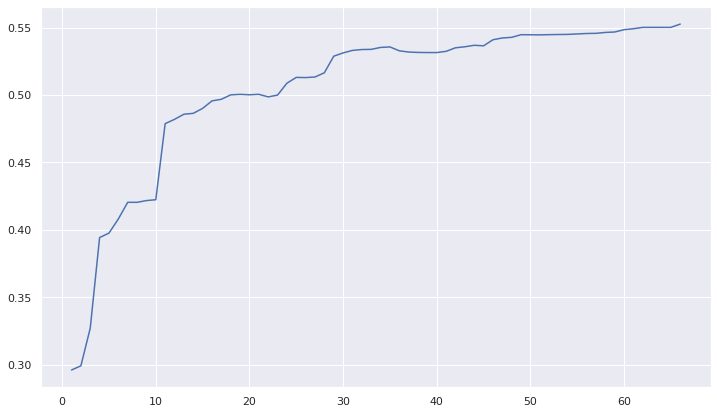

In [ ]:
plt.figure(figsize=(12, 7))
sns.lineplot(x=q_feat, y=r2_list);